# SWI-2023-Groningen - ASMPT Group 
# Two Model Problems
In this section we study two model problems. The first model problem is the damped harmonic oscillation of a single point mass in one degree of freedom, i.e., considering a horizontal displacement only. The second model problem is the damped harmonic oscillation of two interconnected point masses. Also in the second problem we limit ourselves to horizontal displacements. 

We study these model problems to gain insight into the following aspects: 
- the frequency response of a vibrating mechanical systems as function of the mass, stiffness and damping properties of the system; 
- the shape of the optimization landscape by plotting the cost functional as function of the design variables; 
- observability of mechanical systems with spurious parameters (e.g. the stiffness and damping coefficients of the spurious cross-coupling between the $x$-stage and the $y$-stage); 

The introduction of Julia as programming language is motivated by the wish to introduce an eco system that possibly complements Matlab.

This section is subdivived into two subsections, each devoted to a model problem. 

## Import Libraries

In [1]:
using ControlSystems 
using Plots

## Section 1: Single Mass-Damper-Spring  Model 
In this subsection, we study a single mass-damper-spring mechanism. The mass $m$ is assumed to be attached to a reference frame with spring having spring constant $k$ and damper with damping constant $d$. The mass will thus oscillate horizontally around its equilibrium positions. We assume that the mass can be determined a-priori using a scale. This allows us to reduce the design problem from three to two design variables and to consider the scaled stiffness constant $k/m$ and the scaled damping constant $d/m$. 

The goal of this subsection is to:  
- define the second order ODE as equation of motion for an [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator);
- define the [state-space representation](https://en.wikipedia.org/wiki/State-space_representation);
- compute the [transfer function](https://en.wikipedia.org/wiki/Transfer_function) and explore various frequency ranges to determine the spring constant $k$ and the damping parameter $d$. This will motivated a multi-stage optimization approach in the future;
- plot the Bode diagram (see e.g. [wikipedia on Bode diagram](https://en.wikipedia.org/wiki/Bode_plot));   
- plot the Nyquist diagram (see e.g. [wikipedia on Nyquist diagram](https://en.wikipedia.org/wiki/Nyquist_stability_criterion#Nyquist_plot)). This plot will allow to explore alternatives to define the mismatch (or dispancy) between measured and simulated data; 
- study the cost-functional as function of the design variables; 

### Time-Domain Representation
Denote $x(t)$ position and $\dot{x}(t)$ speed at time $t$. We assume stiffness and damping to be proportional to $x(t)$ and $\dot{x}(t)$, respectively. The equation of motion then becomes  
$$ m \, \ddot{x}(t) + d \, \dot{x}(t) + k \, x(t) = F(t)$$
supplied with initial conditions. (Need to be more precise on what $F(t)=$ is. Constant? Harmonic mode?)This equation of motion supplied with initial data for position and velocity can be integrated in time using methods implemented in [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) (insert image from presentation here). 

To cover more realistic scenarios, the model could be extended to include non-linear stiffness (proportional to $x^3(t)$) and/or non-linear friction (proportional to $\dot{x}^2(t)$).

(possibly extend with references to direct and adjoint sensitivity methods and to least-squares optimization along trajectory). 

### State-Space Representation 
The state-space representation of the mechanical system allows to determine the transfer function. We therefore consider this representation here. The state-space representation is written in terms of the state vector $X(t)$ defined as 
$$ X(t) = \begin{pmatrix} x(t) \\ \dot{x}(t) \end{pmatrix}\,.$$ 
The output and control are written as $y(t)$ and $u(t)$, respectively. 
Unlike in more realistic applications, the equation governing the motion of the single point-mass is a linear ordinary differential equation. No linearization (using Matlab's function linmod or equivalent) is thus required. In writing the state-space representation, we consider the position of $m$ to be the only output. This allows us to recover the classical results obtained using Laplace transforms. We furthermore consider to have a single control variable only. This control parameter $u$ has no part in on the output. The state-space representation then reads:  
$$ \dot{X} = A X + B \, u \\ y = C X + D \, u $$ 
where $A = \begin{pmatrix} 0 & 1 \\ -k/m & -d/m \end{pmatrix}$, 
$B = \begin{pmatrix} 0 \\ F_0 \end{pmatrix}$, 
$C = \begin{pmatrix} 1 & 0 \end{pmatrix}$ and $D=0$.
This state-space representation allows to define the velocity (instead of the position) of the point mass $m$ as output. The transfer function will change accordingly. 

The observability and controllability of this state-space representation is discussed on the [wikipedia page on state-space representation](https://en.wikipedia.org/wiki/State-space_representation). Assuming that $F_0 = 1$, we have that 
$$ \text{rank} \begin{bmatrix} B & A \, B \end{bmatrix} 
=  \begin{pmatrix} 0 & 1 \\ 1 & -d/m \end{pmatrix} = 2 \, $$ and that 
$$ \text{rank} \begin{bmatrix} C \\ C A \end{bmatrix} 
=  \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} = 2 \, . $$
The state-space representation is thus both observable and controlable. What this implies for non-linear least-squares problem we wish to solve remains a topic to be explored. 

### Asymptotic Behavior of Transfer Function in Frequency Domain
The transfer function in Laplace domain with variable $s$ is defined as
$$ 
H(s) = \frac{Y(s)}{X(s)} =  \frac{F_0}{m \, s^2 + d \, s + k^2} \, .  
$$
After setting $s = j \, \omega$, we obtain the transfer function in frequency domain
$$ 
H(\omega) = \frac{F_0}{-m \, \omega^2 + j \, d \, \omega + k^2} \, .  
$$
(One can alternatively apply Fourier analysis directly on the equation of motion, thus avoiding the introduction of the Laplace transform). Graphs in frequency domain (see below) confirm that:
- in the limit that $\omega \rightarrow 0$ $H(\omega) = 1/k$. Thus at $\omega=0$, 
$\log( |H(\omega)| ) = \log(1/k)$. This limit thus allows to determine  the spring constant $k$; 
- in the limit that $\omega \rightarrow \infty$ $H(\omega) = 1/(m \, \omega^2)$. Thus in this limit $\log( |H(\omega)| ) = \log(1/(m) -2 \log( \omega )$. This limit should match with the value of $m$. The slope is 40 Db per decade (20 Db (due to units) times slope of 2);  
- the value of the damping coefficient can be determined from the value of $H(\omega)$ in the resonant frequency $\omega_0 = \sqrt{\frac{k}{m}}$; 

Even though the transfer functiin is linear in frequency, it is non-linear in the parameters $k$, $d$ and $m$. The optimization problem we wish to solve is thus <b> non-linear </b> in these parameters.  

### Sample Numerical Values for the x-stage and y-stage of the Wire-Bonder Machine 
We here consider the x-stage and y-stage as independent oscillators (decoupled from the other stages of the machine) and plug in numerical values for the mass, stiffness and damping of these two stages. Our goal here is to generate transfer functions to be used further in this notebook. 

In [11]:
# x-stage as damped oscillator  
m1  = 1.6704;     # point-mass in kg
k11 = 50e6;     # spring constant in N/m  
d11 = 400; # damping constant in (Ns)/m  
freqres1 = sqrt(k11/m1)/(2*pi)  # resonant frequency computed as verification 
F0 = 1;    # amplitude of external forcing 
A = [0 1; -k11/m1 -d11/m1];
B = [0 ; F0]; 
C = [0 1]; # [1 0]; # select position data 
D = [0];   # not used 
yStageSys = ss(A,B,C,D)
# 
# y-stage as damped oscillator
m2 = 0.1363;     # point-mass in kg
k22 = 1.4429;     # spring constant in N/m  
d22 = 0.031; # damping constant in (Ns)/m  
freqres2 = sqrt(k22/m2)/(2*pi)
F0 = 1;    # amplitude of external forcing 
A = [0 1; -k22/m2 -d22/m2];
B = [0 ; F0]; 
C = [0 1]; # [1 0]; # select position data 
D = [0];   # not used 
zStageSys = ss(A,B,C,D)

StateSpace{Continuous, Float64}
A = 
   0.0                 1.0
 -10.586206896551724  -0.22743947175348495
B = 
 0.0
 1.0
C = 
 0.0  1.0
D = 
 0.0

Continuous-time state-space model

The results that follow confirm the analytically derived expressions for the transfer function. 

In [12]:
# compute transfer function 
yStagetf = tf(yStageSys)
zStagetf = tf(zStageSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                       1.0s
--------------------------------------------------
1.0s^2 + 0.22743947175348495s + 10.586206896551724

Continuous-time transfer function model

### Bode plot
Here we make Bode plots of the transfer function of the x-stage and y-stage as isolated damped oscillators. 

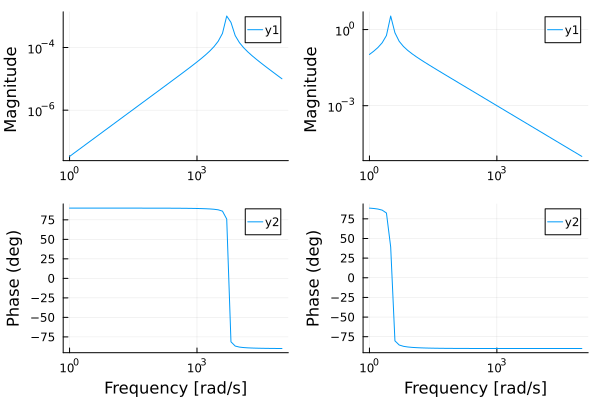

In [13]:
freqrange = exp10.(0:0.1:5)
p1 = bodeplot(yStagetf,freqrange)
p2 = bodeplot(zStagetf,freqrange)
plot(p1,p2, layout=(1,2))

### Nyquist Plot
Here we make Nyquist plots of the transfer function of the x-stage and y-stage as isolated damped oscillators. We should obtain figures similar to [sample Nyquist plot](https://math.mit.edu/~stoopn/18.031/class2-reading.pdf), but are not quite there yet. 

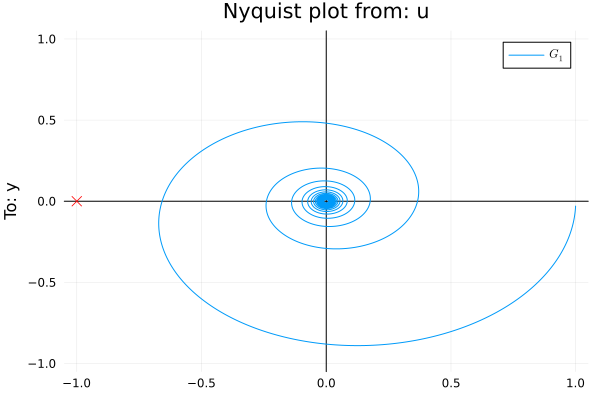

In [14]:
# synthetic example 
w = exp10.(LinRange(-2, 2, 2000))
P = tf(1, [1, 1]) * delay(2) # Plant with delay on the input
nyquistplot(P, w)

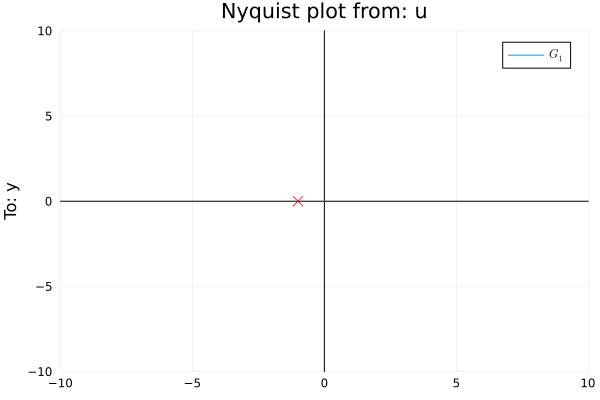

In [15]:
freqrange = exp10.(3:0.1:5)
nyquistplot(yStagetf,freqrange, xlims=(-10, 10), ylims=(-10, 10))

### Numerical Values of Transfer Function 
Here we inspect numerical values of the transfer function. This analysis will be a value further in the notebook. 

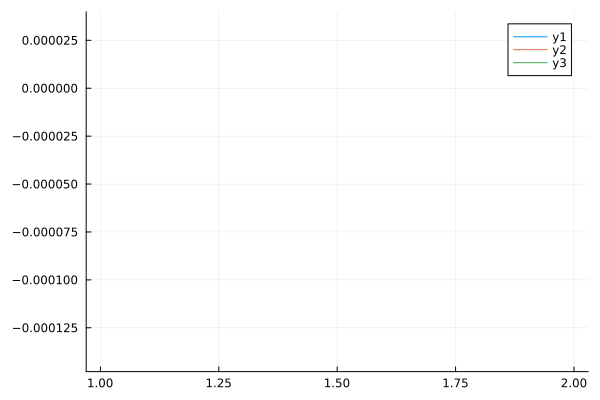

In [16]:
# evaluate transfer fct in frequency values 
freqrange = exp10.(3:1:5)
values = yStagetf.(sqrt(Complex(-1))*freqrange);
# plot(real(values), "*")
# print(real(values[1,1]))
plot(imag(values))

### Study of Cost Functional in Single Design Parameter
The optimization landscape depends on the number of frequency samples (among other factors). 

In [221]:
function constructSimulateTf(m,k,d)
  F0 = 1
  A = [0 1; -k/m -d/m];
  B = [0 ; F0]; 
  C = [1 0];  
  D = [0];   
  mySys = ss(A,B,C,D) 
  mytf  = tf(mySys)  
  return mytf
end 

constructSimulateTf (generic function with 1 method)

In [222]:
m = 1.6704;   # point-mass in kg
k = 50e6;     # spring constant in N/m  
d = 400;      # damping constant in (Ns)/m  

constructSimulateTf(m,k,d)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
           2.842170943040401e-14s + 1.0
---------------------------------------------------
1.0s^2 + 239.46360153256703s + 2.9932950191570874e7

Continuous-time transfer function model

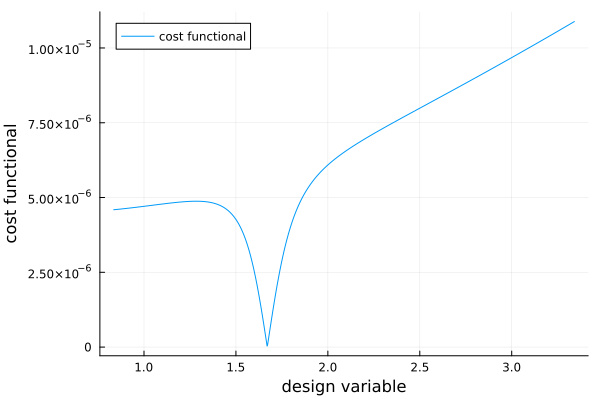

In [226]:
function constructSimulateTf(m,k,d)
  F0 = 1
  A = [0 1; -k/m -d/m];
  B = [0 ; F0]; 
  C = [1 0];  
  D = [0];   
  mySys = ss(A,B,C,D) 
  mytf  = tf(mySys)  
  return mytf
end 

# set nominal values 
m = 1.6704;   # point-mass in kg
k = 50e6;     # spring constant in N/m  
d = 400;      # damping constant in (Ns)/m  

freqrange = exp10.(0:0.001:5)

pointSystf = constructSimulateTf(m,k,d)
pointSystfval = pointSystf.(sqrt(Complex(-1))*freqrange)

minVar1 = 0.5*m
maxVar1 = 2*m
stepVar1 = (maxVar1 - minVar1)/1000
vecVar1 = Vector(minVar1:stepVar1:maxVar1) 

costf = zeros(size(vecVar1))

for i in 1:length(vecVar1)
  thistf = constructSimulateTf(vecVar1[i],k,d)
  thistfval = thistf.(sqrt(Complex(-1))*freqrange)
  mismatch = thistfval - pointSystfval
  costf[i] = norm(mismatch)
end 

plot(vecVar1, costf, xlabel="design variable", ylabel="cost functional",label="cost functional")
#savefig("output.png")

### Study of Cost Functional in Two Design Parameters 

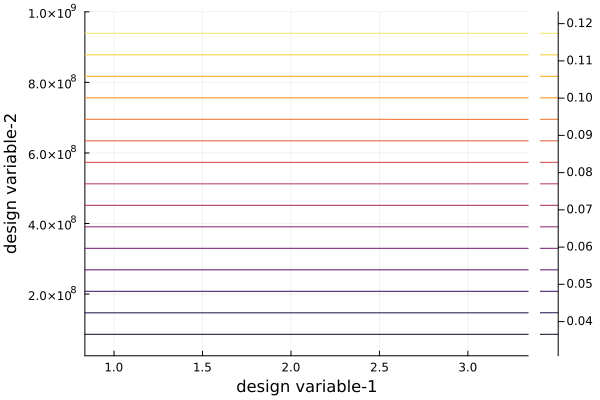

In [234]:
# set nominal values 
m = 1.6704;   # point-mass in kg
k = 50e6;     # spring constant in N/m  
d = 400;      # damping constant in (Ns)/m  

freqrange = exp10.(0:0.001:5)

pointSystf = constructSimulateTf(m,k,d)
pointSystfval = pointSystf.(sqrt(Complex(-1))*freqrange)

minVar1 = 0.5*m
maxVar1 = 2*m
stepVar1 = (maxVar1 - minVar1)/100
vecVar1 = Vector(minVar1:stepVar1:maxVar1) 

minVar2 = 0.5*k
maxVar2 = 20*k
stepVar2 = (maxVar2 - minVar2)/100
vecVar2 = Vector(minVar2:stepVar2:maxVar2) 

costf = zeros(length(vecVar1),length(vecVar2))

for i in 1:length(vecVar1)
  for j in 1:length(vecVar2)
    thistf = constructSimulateTf(vecVar1[i],vecVar1[j],d)
    thistfval = thistf.(sqrt(Complex(-1))*freqrange)
    mismatch = thistfval - pointSystfval
    costf[i,j] = norm(mismatch)
  end
end 

contour(vecVar1, vecVar2, costf, xlabel="design variable-1", ylabel="design variable-2")

In [225]:
constructSimulateTf(vecVar1[1],k,d)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                       1.0
-------------------------------------------------
1.0s^2 + 478.9272030651341s + 5.986590038314174e7

Continuous-time transfer function model

## Section 2: Double Masses-Dampers-Springs
(not clear to Domenico how Collin intended to incorporate parasitic effects in the model: should coupling and/or parasitic effects be included in the differential equation of motion, in the definition of the observable output or both)

In this section, we study a mechanism consisting of two point masses. The first mass $m_1$ is assumed to be attached to the wall with a spring having spring constant $k_{11}$ and a damper with damping constant $d_{11}$. The second mass is assumed to be attached at two locations. First, the mass $m_2$ is assumed to be attached to the wall with a spring having spring constant $k_{22}$ and a damper with damping constant $d_{22}$. Second, the mass $m_2$ is assumed to be attached to the mass $m_1$ with a spring having spring constant $k_{12}$ and a damper with damping constant $d_{12}$. 

Let $x(t)$ and $\dot{x}(t)$ denote the position and speed of point mass $m_1$ at time $t$, respectively. Similarly, let $y(t)$ and $\dot{y}(t)$ denote the position and the speed of point mass $m_2$ at time $t$, respectively. The variable $x(t)$ is the variable to be observed while $y(t)$ is the hidden variable. The mass $m_1$ and $m_2$ have external excitation $F(t)$ and $0$, respectively.  

Our goal here is to extend the previous analysis. 

### Equations of Motion in Time Domain
$$
m_1 \, \ddot{x} = -k_{11} \, x - k_{12} \, (x-y) 
                  -d_{11} \, \dot{x} - d_{12} \, (\dot{x}-\dot{y}) + F_0(t) \\
m_2 \, \ddot{y} = -k_{22} \, y - k_{21} \, (y -x) 
                  -d_{11} \, \dot{y} - d_{21} \, (\dot{y}-\dot{x})
$$

### Time-Domain Representation  
The mass matrix $M$ is given by $M = \begin{pmatrix} m_1 & 0 \\ 0 & m_2 \end{pmatrix}$. The mass matrix $M$ is thus diagonal.

The stiffness matrix $K$ is given by  
$K = \begin{pmatrix} k_{11} + k_{12} & -k_{12} \\ -k_{21} & k_{22}+k_{21} \end{pmatrix}$. The stiffness matrix is thus symmetric. The off-diagonal contributions introduce cross-coupling between the masses $m_1$ and $m_2$.  

The damping matrix $D$ is given by $D = \begin{pmatrix} d_{11} + d_{12} & -d_{12} \\ -d_{21} & d_{22}+d_{21}\end{pmatrix}$. Cross-coupling is agian introduced. 

Then equations of motion in matrix-vector form become  
$$ M \, \begin{pmatrix} \ddot{x}(t) \\ \ddot{y}(t) \end{pmatrix}
   + D \, \begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \end{pmatrix}
   + K \, \begin{pmatrix} x(t) \\ y(t) \end{pmatrix}
   = \begin{pmatrix} F_0(t) \\ 0 \end{pmatrix}$$
supplied with initial conditions. (model is linear and has constant coefficients. Laplace transform carries over to this case). 

### State-Space Representation

In [7]:
m1 = 1; m2 = 0.1;  # value of point-masses 
M = [m1 0; 0 m2];  # mass matrix 
k11 = 100; k22 = 100; k12 = 0.1; k21 = k12;   # stiffness coefficients 
K = [k11+k12 -k12; -k21 k22+k21];       # stiffness matrix 
d11 = 1e-3; d22 = 1e-3; d12 = 1e-3; d21 = d12;   # damping coefficients;
D = 1e-6*[d11+d12 -d12; -d21 d22+d21];  # stiffness matrix
F0 = 1; G0 = 2; 
A = [0 0 1 0; 0 0 0 1; M\K M\D];
B = [0 0; 0 0; F0 0; 0 G0]; 
C = [1 0 0 0; 0 1 0 0 ]; # select position of mass m_1 as observable
DD = [0 0 ; 0 0];  
twoMassSys = ss(A,B,C,DD)

StateSpace{Continuous, Float64}
A = 
   0.0     0.0               1.0      0.0
   0.0     0.0               0.0      1.0
 100.1    -0.1               2.0e-9  -1.0e-9
  -1.0  1000.9999999999999  -1.0e-8   2.0e-8
B = 
 0.0  0.0
 0.0  0.0
 1.0  0.0
 0.0  2.0
C = 
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
D = 
 0.0  0.0
 0.0  0.0

Continuous-time state-space model

## Transfer Matrix in Frequency Domain 
Scalar transfer function (as in first model problem) generalizes to a 2-by-2 transfer matrix. In frequency domain where as before $s = j \, \omega$, we have that 
$$ F(\omega) = Z(\omega) \, X(\omega) \, , $$ 
where $Z(\omega)$ is the impedance matrix given by $Z(\omega) = - \omega^2 M - j \, \omega D + K$. Solving for the unknown displacement can thus be done as $X(\omega) = H(\omega) F(\omega)$ where 
$$ H(\omega) = Z^{-1}(\omega)$$
is the transfer matrix. This transfer function and its implications for the model problem we consider here are beautifully explained by Prof. J. Kim Vandiver in [this video](https://www.youtube.com/watch?v=fK9AGvLf3yw&t=2127s). 

In [8]:
mytf = tf(twoMassSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
1.0658141036401503e-14s^3 + 1.0000000000004547s^2 - 2.0003426470793784e-8s - 1001.0000000002474
-----------------------------------------------------------------------------------------------
       1.0s^4 - 2.200000892571552e-8s^3 - 1101.1s^2 + 4.0020117921812925e-6s + 100200.0

Input 1 to output 2
1.0658141036401503e-14s^3 + 2.2737367544323206e-13s^2 - 1.0018538887379691e-8s - 1.0000000002619345
---------------------------------------------------------------------------------------------------
         1.0s^4 - 2.200000892571552e-8s^3 - 1101.1s^2 + 4.0020117921812925e-6s + 100200.0

Input 2 to output 1
3.907985046680551e-14s^3 + 6.821210263296962e-13s^2 - 2.0181687432341278e-9s - 0.20000000009895302
--------------------------------------------------------------------------------------------------
         1.0s^4 - 2.200000892571552e-8s^3 - 1101.1s^2 + 4.0020117921812925e-6s + 100200.0

Input 2 

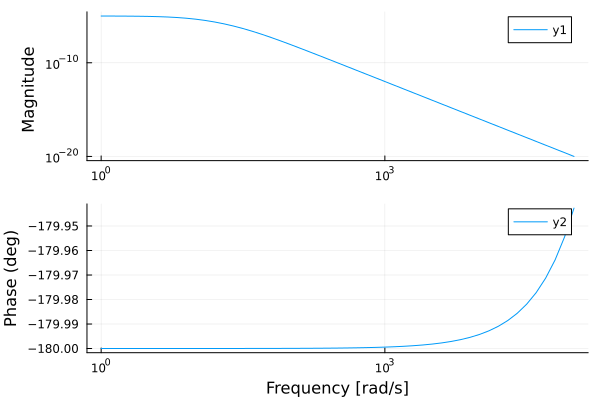

In [10]:
freqrange = exp10.(0:0.1:5)
bodeplot(twoMassSys[2,1],freqrange)
# savefig("output.png")

## Section 3:/ Three Masses-Dampers-Springs

In [250]:
m1 = 100; m2 = 1; m3 = 0.1   # value of point-masses 
M = [m1 0 0; 0 m2 0; 0 0 m3 ];  # mass matrix 
k11 = 1; k22 = 0.1; k12 = 0.1;   # stiffness coefficients 
K = [k11+k22 -k11 -k22;-k11 k11+k12 -k12; -k22 -k12 k22+k12];       # stiffness matrix 
d11 = 1e-1; d22 = 0.1e-1; d12 = 0.1e-1;
D = [d11+d22 -d11 -d22;-d11 d11+d12 -d12; -d22 -d12 d22+d12];  # stiffness matrix
F0 = 1; G0 = 2; H0 = 3;
A = [0 0 0 1 0 0; 0 0 0 0 1 0; 0 0 0 0 0 1; M\K M\D];
B = [0 0 0; 0 0 0; 0 0 0; F0 0 0; 0 G0 0;  0 0 H0 ]; 
C = [1 0 0 0 0 0; 0 1 0 0 0 0; 0 0 0 0 0 0]; # select position of mass m_1 as observable
DD = [0 0 0; 0 0 0; 0 0 0];  
threeMassSys = ss(A,B,C,DD)

StateSpace{Continuous, Float64}
A = 
  0.0                    0.0    0.0     1.0                   0.0                   0.0
  0.0                    0.0    0.0     0.0                   1.0                   0.0
  0.0                    0.0    0.0     0.0                   0.0                   1.0
  0.011000000000000001  -0.01  -0.001   0.0011               -0.001                -0.0001
 -1.0                    1.1   -0.1    -0.1                   0.11                 -0.01
 -1.0                   -1.0    2.0    -0.09999999999999999  -0.09999999999999999   0.19999999999999998
B = 
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  2.0  0.0
 0.0  0.0  3.0
C = 
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
D = 
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

Continuous-time state-space model

In [139]:
threeMassSys = ss(A,B,C,DD)
threeMasstf = tf(threeMassSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
Input 1 to output 1
       -1.609823385706477e-15s^5 + 1.0000000000000022s^4 - 0.3099999999999977s^3 - 3.078999999999999s^2 + 0.4199999999999987s + 2.099999999999996
--------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 - 0.3110999999999999s^5 - 3.089768999999999s^4 + 0.42461999999999955s^3 + 2.123099999999999s^2 + 1.2076244845153607e-16s - 1.9006508184977566e-33

Input 1 to output 2
    -9.43689570931383e-16s^5 - 3.9968028886505635e-15s^4 - 0.09999999999999809s^3 - 0.9789999999999954s^2 + 0.4200000000000016s + 2.1000000000000045
--------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^6 - 0.3110999999999999s^5 - 3.089768999999999s^4 + 0.42461999999999955s^3 + 2.123099999999999s^2 + 1.2076244845153607e-16s - 1.90

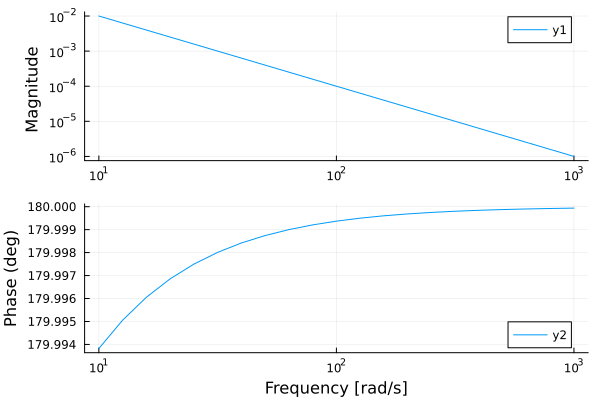

In [152]:
freqrange = exp10.(1:0.1:3)
bodeplot(threeMasstf[1,1],freqrange)